# Books Recommend Seach System

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime
import sklearn
import re
from scipy import stats
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
from datetime import date
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from fuzzywuzzy import fuzz
from nltk.tokenize import word_tokenize
import scipy as sp
import xgboost as xgb
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, auc,\
                            roc_auc_score
import warnings
warnings.filterwarnings('ignore')

In [4]:
books = pd.read_csv('./books.csv', index_col=1)
books = books.iloc[:, 1:]
ratings = pd.read_csv('./ratings.csv')
book_tags = pd.read_csv('./book_tags.csv')
tags = pd.read_csv('./tags.csv')
to_read = pd.read_csv('to_read.csv')

## 1. EDA

### 1.1. To_read

In [3]:
to_read.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 912705 entries, 0 to 912704
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   user_id  912705 non-null  int64
 1   book_id  912705 non-null  int64
dtypes: int64(2)
memory usage: 13.9 MB


### 1.2. Rating

In [4]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5976479 entries, 0 to 5976478
Data columns (total 3 columns):
 #   Column   Dtype
---  ------   -----
 0   user_id  int64
 1   book_id  int64
 2   rating   int64
dtypes: int64(3)
memory usage: 136.8 MB


In [5]:
ratings.head()

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3


In [6]:
'users', len(ratings.user_id.unique()), \
'books', len(ratings.book_id.unique()), \
'ratings', len(ratings)

('users', 53424, 'books', 10000, 'ratings', 5976479)

In [7]:
r_ub = ratings.groupby(['user_id', 'book_id'])
ratings[r_ub['rating'].transform('size') != 1]

,user_id,book_id,rating


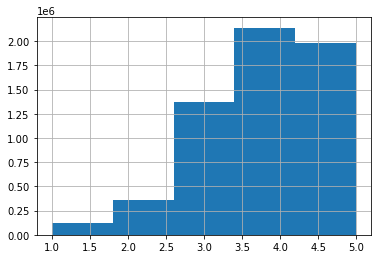

In [8]:
ratings.rating.hist( bins = 5 );

### 1.3 Books
missing data: 
isbn 700 rows  
isbn13 ~600  
original_publication_year 21  
original_title ~600 same as isbn13  
language_code ~1000

In [9]:
books.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   goodreads_book_id          10000 non-null  int64  
 1   best_book_id               10000 non-null  int64  
 2   work_id                    10000 non-null  int64  
 3   books_count                10000 non-null  int64  
 4   isbn                       9300 non-null   object 
 5   isbn13                     9415 non-null   float64
 6   authors                    10000 non-null  object 
 7   original_publication_year  10000 non-null  float64
 8   original_title             9415 non-null   object 
 9   title                      10000 non-null  object 
 10  language_code              9344 non-null   object 
 11  average_rating             10000 non-null  float64
 12  ratings_count              10000 non-null  int64  
 13  work_ratings_count         10000 non-null  int

In [10]:
books.head(3).T

book_id,1,2,3
goodreads_book_id,2767052,3,41865
best_book_id,2767052,3,41865
work_id,2792775,4640799,3212258
books_count,272,491,226
isbn,439023483,439554934,316015849
isbn13,9.78044e+12,9.78044e+12,9.78032e+12
authors,Suzanne Collins,"J.K. Rowling, Mary GrandPré",Stephenie Meyer
original_publication_year,2008,1997,2005
original_title,The Hunger Games,Harry Potter and the Philosopher's Stone,Twilight
title,"The Hunger Games (The Hunger Games, #1)",Harry Potter and the Sorcerer's Stone (Harry P...,"Twilight (Twilight, #1)"


### 1.3. Book_tags

In [11]:
book_tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999912 entries, 0 to 999911
Data columns (total 3 columns):
 #   Column             Non-Null Count   Dtype
---  ------             --------------   -----
 0   goodreads_book_id  999912 non-null  int64
 1   tag_id             999912 non-null  int64
 2   count              999912 non-null  int64
dtypes: int64(3)
memory usage: 22.9 MB


In [12]:
book_tags.head()

,goodreads_book_id,tag_id,count
0,1,30574,167697
1,1,11305,37174
2,1,11557,34173
3,1,8717,12986
4,1,33114,12716


### 1.4. Tags

In [13]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34252 entries, 0 to 34251
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   tag_id    34252 non-null  int64 
 1   tag_name  34252 non-null  object
dtypes: int64(1), object(1)
memory usage: 535.3+ KB


In [14]:
tags.head()

,tag_id,tag_name
0,0,-
1,1,--1-
2,2,--10-
3,3,--12-
4,4,--122-


### 1.5. Data Cleansing

#### Ratings, no missing data, no few rating per user, no cleaning need

#### Books: publication year, language need to be handled

- book_tags

In [15]:
book_tags.drop_duplicates(inplace=True)

### 1.6. Formal EDA and Features Generation

#### Ratings

##### distribution of rating: many are 3, 4 and 5

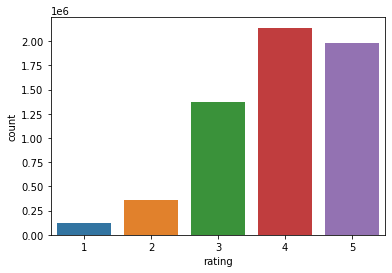

In [16]:
sns.countplot(x='rating', data=ratings);

##### distribution of number of Rating per user: normal distribution aroudn 110 ratings per user  
later check more frequent raters vs less frequent raters on ratings

In [17]:
r_u_cnt = ratings.groupby('user_id').rating.count()

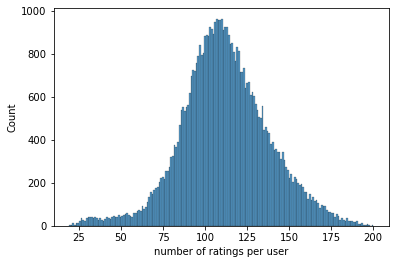

In [18]:
ax = sns.histplot(data=r_u_cnt, bins=180)
ax.set(xlabel='number of ratings per user');

##### distribution of Mean Rating Per User: normal dist around 4  
some ppl like giving 5, meaning they like all the books (low standard) or they only rate good books; And no downvoters rating all 1. These might be good indicator for collaborative filtering. Can shift to std normal distribution to get rid of the tendency from diff users (high standard and low standard)

In [19]:
r_u_mean = ratings.groupby('user_id').rating.mean()

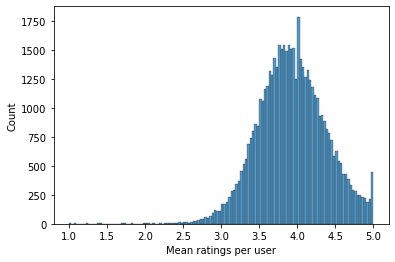

In [20]:
ax = sns.histplot(data=r_u_mean)
ax.set(xlabel='Mean ratings per user');

##### distribution of number of rating per book by sign-in user: many are 100-200 ratings, enough number for true rate

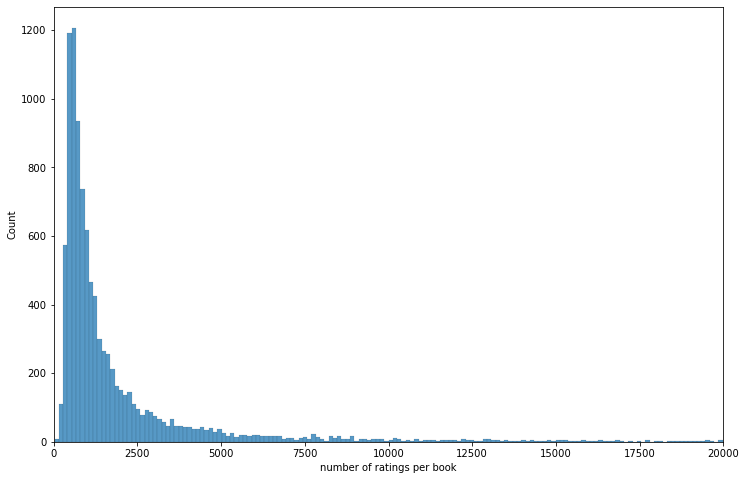

In [21]:
r_b_cnt = ratings.groupby('book_id').rating.sum() 
plt.figure(figsize=(12, 8))
ax = sns.histplot(data=r_b_cnt)
ax.set(
    xlabel='number of ratings per book',
#     xticks=np.logspace(1, 3, num=7, base=10),
    xlim=[0, 20000], 
);
# ax.tick_params(axis='x', which='both', bottom=True)
# ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())

[(0.0, 100000.0)]

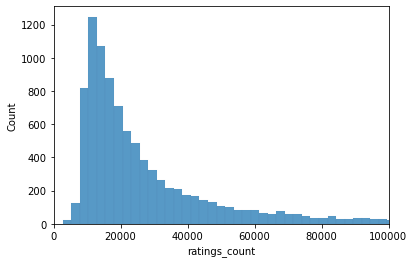

In [22]:
ax = sns.histplot(data=books.ratings_count,
                 )
ax.set(
      xlim=[0, 10**5]
)

##### distribution of Mean Rating Per Book by sign-in user: normal dist around 4, almost no books higher than 4.6

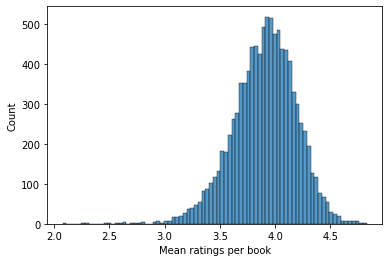

In [23]:
r_b_mean = ratings.groupby('book_id').rating.mean()
ax = sns.histplot(data=r_b_mean)
ax.set(xlabel='Mean ratings per book');

### tags

##### distribution of Book Genres (from tags): hardcore tags to be matched with goodreads' tags, and only use these tags for now  

Fiction, fantasy etc tags are popular

In [24]:
genres = ["Art", "Biography", "Business", "Chick Lit", "Children's", "Christian", "Classics",
          "Comics", "Contemporary", "Cookbooks", "Crime", "Ebooks", "Fantasy", "Fiction",
          "Gay and Lesbian", "Graphic Novels", "Historical Fiction", "History", "Horror",
          "Humor and Comedy", "Manga", "Memoir", "Music", "Mystery", "Nonfiction", "Paranormal",
          "Philosophy", "Poetry", "Psychology", "Religion", "Romance", "Science", "Science Fiction", 
          "Self Help", "Suspense", "Spirituality", "Sports", "Thriller", "Travel", "Young Adult"]
genres = list(map(str.lower, genres))

In [25]:
built_in_tags = tags[tags.tag_name.str.lower().isin(genres)]
built_in_book_tags = book_tags[book_tags.tag_id.isin(built_in_tags.tag_id)]
genres_built_in = built_in_book_tags.merge(built_in_tags, on='tag_id')

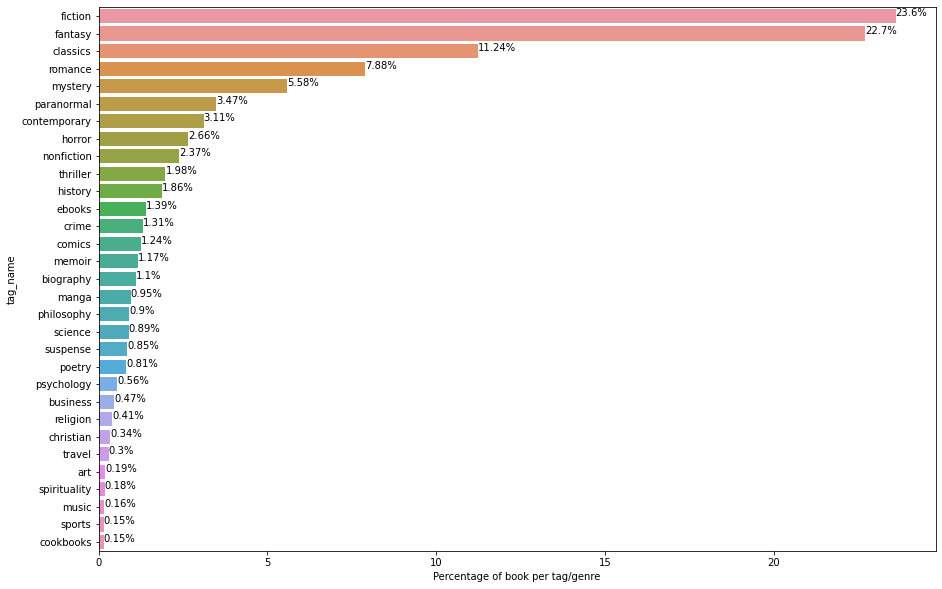

In [26]:
tagname_totalcnt = built_in_book_tags['count'].sum()
bibt_tagname_cnt = pd.DataFrame(built_in_book_tags.groupby('tag_id')['count']. \
                                pipe(lambda x: 100. * x.sum() / tagname_totalcnt)). \
                    set_index(built_in_tags.tag_name)
bibt_tagname_cnt.sort_values('count', ascending=False, inplace=True)
plt.figure(figsize=(15, 10))
ax = sns.barplot(
    data=bibt_tagname_cnt,
    x='count',
    y=bibt_tagname_cnt.index,
#     orient='h'
                 )
ax.set(xlabel='Percentage of book per tag/genre');
for i, v in enumerate(bibt_tagname_cnt['count']):
    ax.text( v, i, str(round(v, 2)) + '%' )

### Books

#### authors:  
generate feature:  
- number of authors  

- number of autoher, higher rating

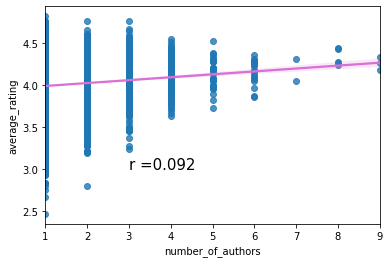

In [27]:
books['n_authors'] = books.apply(lambda x: len(x.authors.split(',')), axis=1)
n_authors = books[books['n_authors'] < 10]['n_authors']

ax = sns.regplot(
    x=n_authors, 
    y=books[books['n_authors'] < 10]['average_rating'], 
    line_kws={'color':'orchid'})

ax.annotate('r =' + str(round(stats.pearsonr(n_authors,
                                             books[books['n_authors'] < 10]['average_rating'])[0], 3)),
            xy=(3,3), fontsize=15);
plt.xlabel('number_of_authors');

#### Years:   
 generate feature:  
- year until now

In [28]:
books['years_until_now'] = books.original_publication_year.astype(int).map(lambda x: date.today().year - x)

#### title:
generate feature:  
- title changed? (bool)  
- title length
- has_subtitle?(bool)

In [29]:
books['title_changed'] = 1
books.loc[books.title == books.original_title, 'title_changed'] = 0

- title length: vs rating

In [30]:
books['title_length'] = books.title.transform(lambda x: len(x.split()) )

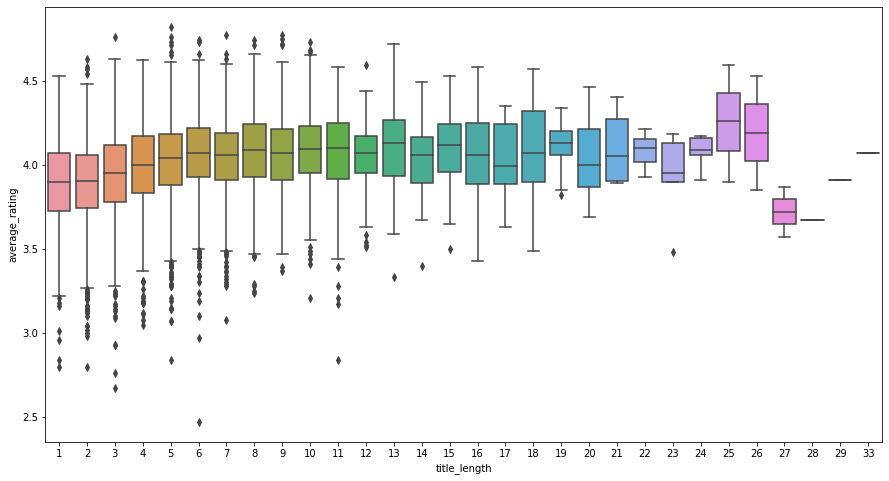

In [31]:
plt.figure(figsize=(15,8))
sns.boxplot(x='title_length',
            y='average_rating',
            data=books
           );

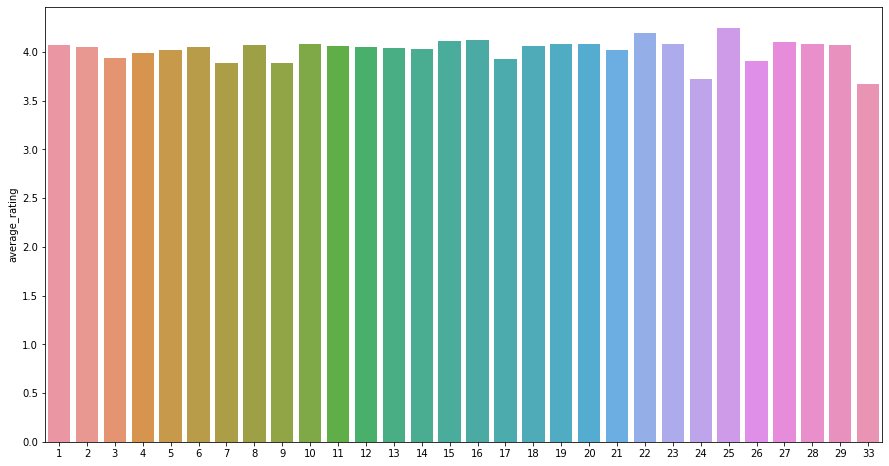

In [32]:
plt.figure(figsize=(15,8))
sns.barplot(
    x=books['title_length'].unique(),
    y=books.groupby('title_length')['average_rating'].mean(),
    data=books,
    orient='v'
           );

- Subtitle: improve books' rating

<AxesSubplot:xlabel='has_subtitle', ylabel='average_rating'>

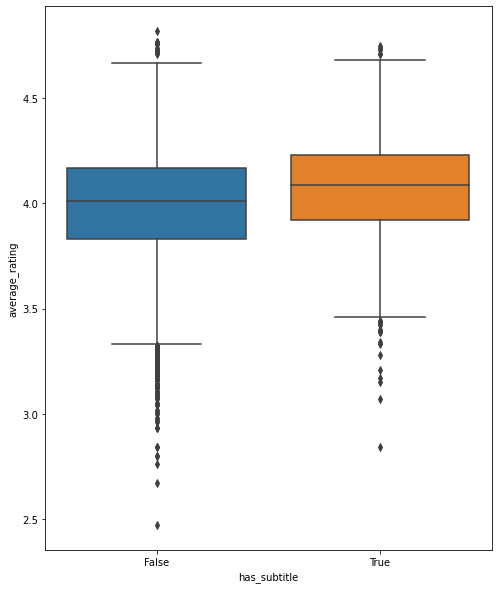

In [33]:
books['has_subtitle'] = books.title.str.contains(':', regex=False)
plt.figure(figsize=(8,10))
sns.boxplot(
    x='has_subtitle',
    y='average_rating',
    data=books
)

#### Languages:   
some books with diff languages?   
generate feature: 
- is_english book?

In [34]:
b_lang_cnt = books.language_code.value_counts()
b_lang_cnt.columns = ['count']
b_lang_cnt.head()

eng      6767
en-US    2070
en-GB     257
ara        64
en-CA      58
Name: language_code, dtype: int64

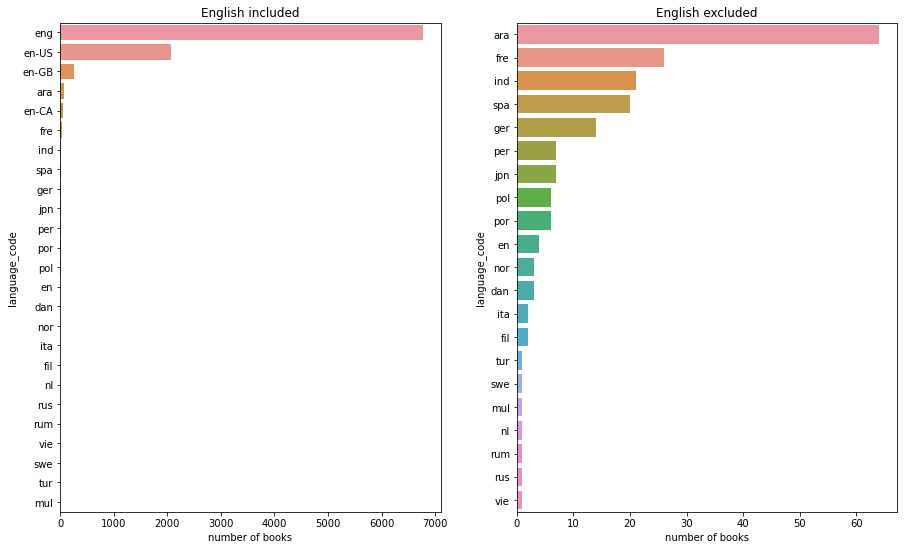

In [35]:
f, axes = plt.subplots(1, 2, figsize=(15,9))
axes[0] = sns.countplot(
    y=books.language_code,
    order=books.language_code.value_counts().index,
    ax=axes[0]
           );
exclude_eng = books[~books['language_code'].isin(["en-US", "en-GB", "eng", "en-CA"]
                         )].language_code
axes[1] = sns.countplot(
    y=exclude_eng,
    order=exclude_eng.value_counts().index,
    ax=axes[1]
           );

axes[0].set(xlabel='number of books', title='English included');
axes[1].set(xlabel='number of books', title='English excluded');

In [36]:
books['is_english'] = 0
books.loc[books.language_code.isin(["en-US", "en-GB", "eng", "en-CA"]), 'is_english'] = 1

#### series of books: 
always given by #, good indicator for recommendation, 
generate features: 
- series
- number of books in a series
- etc

In [37]:
series = books[books.title.str.contains('\(.*[:#].*\)')]
series['series'] = series['title'].str.findall('\(.*[,:]').\
apply(lambda x: ''.join(map(str, x))).apply(lambda x: x[1:-1])
series[['goodreads_book_id', 'title', 'average_rating']];

<ipython-input-37-9d6413010709>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series['series'] = series['title'].str.findall('\(.*[,:]').\


In [38]:
books['series'] = books.join(series.series).series

- number of books in series  
more books in a series, higher rating

In [39]:
books['n_books_in_series'] = books.groupby('series')['series'].transform('count').fillna(0)

0.061740501831476224


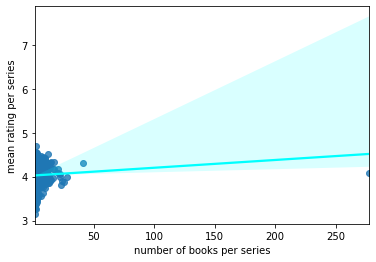

In [40]:
r2 = stats.linregress(series.groupby('series')['series'].count(), 
                      series.groupby('series')['average_rating'].mean(),
                     )[2]
print(r2)
ax = sns.regplot(x=series.groupby('series')['series'].count(),
                 y=series.groupby('series')['average_rating'].mean(),
#                 data=books,
            line_kws={'color':'cyan'}, 
           )
ax.set(xlabel='number of books per series', ylabel='mean rating per series');

#### Top rated from books

In [41]:
books.sort_values(
    by='average_rating',
    ascending=False
    ).loc[: , ['title', 'ratings_count', 'average_rating']].head()

,title,ratings_count,average_rating
book_id,,,
3628,The Complete Calvin and Hobbes,28900,4.82
3275,"Harry Potter Boxed Set, Books 1-5 (Harry Potte...",33220,4.77
862,"Words of Radiance (The Stormlight Archive, #2)",73572,4.77
8854,Mark of the Lion Trilogy,9081,4.76
7947,ESV Study Bible,8953,4.76


#### Top popular (number of rate) from books

In [42]:
books.sort_values(
    by='ratings_count',
    ascending=False
    ).loc[: , ['title', 'ratings_count', 'average_rating']].head()

,title,ratings_count,average_rating
book_id,,,
1,"The Hunger Games (The Hunger Games, #1)",4780653,4.34
2,Harry Potter and the Sorcerer's Stone (Harry P...,4602479,4.44
3,"Twilight (Twilight, #1)",3866839,3.57
4,To Kill a Mockingbird,3198671,4.25
5,The Great Gatsby,2683664,3.89


#### ralation with ratings: only small correlations, mean rating not depend on meta-features


In [43]:
books_corr = books[['books_count','original_publication_year',
                   'average_rating','ratings_count','work_ratings_count',
                   'work_text_reviews_count',
                   'ratings_1', 'ratings_2', 'ratings_3', 'ratings_4', 'ratings_5']].corr()

In [44]:
books_corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,books_count,original_publication_year,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5
books_count,1.00,-0.32,-0.07,0.32,0.33,0.20,0.23,0.33,0.38,0.35,0.28
original_publication_year,-0.32,1.00,0.02,-0.02,-0.03,0.03,-0.02,-0.04,-0.04,-0.03,-0.02
average_rating,-0.07,0.02,1.00,0.04,0.05,0.01,-0.08,-0.12,-0.07,0.04,0.12
ratings_count,0.32,-0.02,0.04,1.00,1.00,0.78,0.72,0.85,0.94,0.98,0.96
work_ratings_count,0.33,-0.03,0.05,1.00,1.00,0.81,0.72,0.85,0.94,0.99,0.97
work_text_reviews_count,0.20,0.03,0.01,0.78,0.81,1.00,0.57,0.70,0.76,0.82,0.76
ratings_1,0.23,-0.02,-0.08,0.72,0.72,0.57,1.00,0.93,0.80,0.67,0.60
ratings_2,0.33,-0.04,-0.12,0.85,0.85,0.70,0.93,1.00,0.95,0.84,0.71
ratings_3,0.38,-0.04,-0.07,0.94,0.94,0.76,0.80,0.95,1.00,0.95,0.83
ratings_4,0.35,-0.03,0.04,0.98,0.99,0.82,0.67,0.84,0.95,1.00,0.93


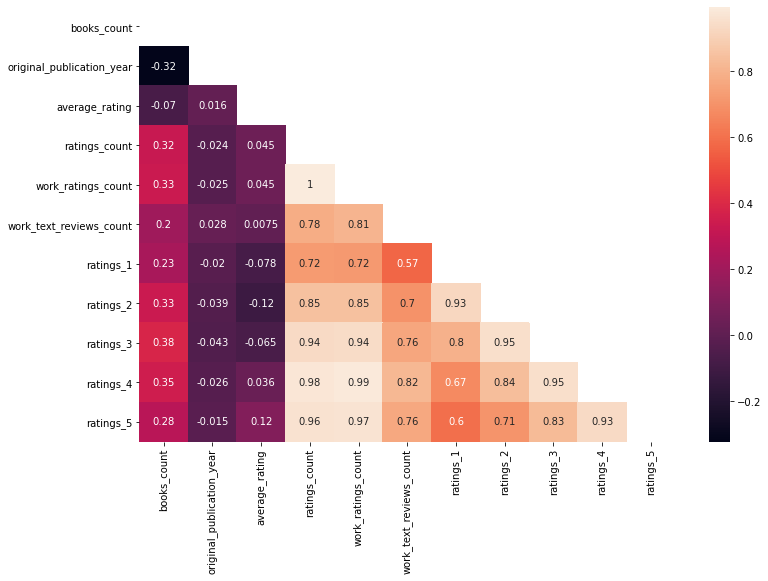

In [45]:
mask = np.zeros_like(books_corr, dtype=bool)
mask[np.triu_indices_from(mask)] = 1
plt.figure(figsize=(12, 8))
sns.heatmap(books_corr, 
#             xticklabels=books_corr.columns.values,
#             yticklabels=books_corr.columns.values,
            mask=mask,
            annot=True
           );

- relationship between rating_count and average_rating: only 0.04, meaning even when books are popular, avg ratings doesn't get better

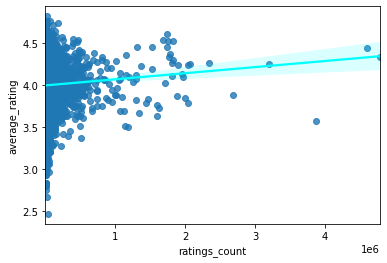

In [46]:
ax = sns.regplot(x='ratings_count', y='average_rating', 
            data=books,
            line_kws={'color':'cyan'}, 
            
           )

- book_count -- multiple editions of each book: assume more editions, the book is more popular and better. But in fact, more editions, book has lower avg rating. reason might be due to with more editions, books go to different langauge, quality of the book and culture from different users make them lower

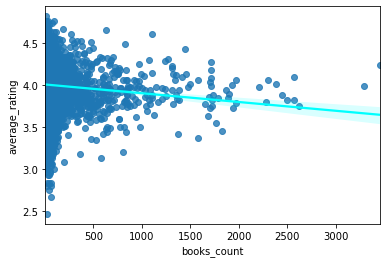

In [47]:
r2 = stats.linregress(books['books_count'], books['average_rating'])[2]
ax = sns.regplot(x='books_count', y='average_rating', 
            data=books,
            line_kws={'color':'cyan', 'label': r2}, 
           )


- frequent raters rate lower, reason may be they are more critical when the more they read, with r2 -0.08 

-0.08253402126338476


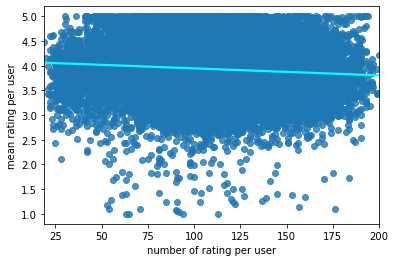

In [48]:
r2 = stats.linregress(ratings.groupby('user_id')['user_id'].count(), ratings.groupby('user_id')['rating'].mean())[2]
print(r2)
ax = sns.regplot(x=ratings.groupby('user_id')['user_id'].count(),
                 y=ratings.groupby('user_id')['rating'].mean(), 
#                 data=books,
            line_kws={'color':'cyan'}, 
           )
ax.set(xlabel='number of rating per user', ylabel='mean rating per user');

#### To Read 
generate feature on books:
- number of people wants to read the book

In [49]:
to_r = to_read.merge(books.title, on='book_id')

In [50]:
books['n_user_to_read'] = to_read.groupby('book_id').book_id.count()
books['n_user_to_read'].fillna(0, inplace=True)

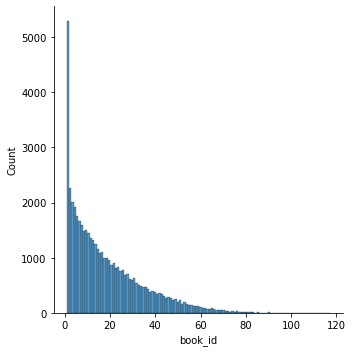

In [51]:
sns.displot(
    to_read.groupby('user_id').count(),
    x='book_id',
    bins=115
);

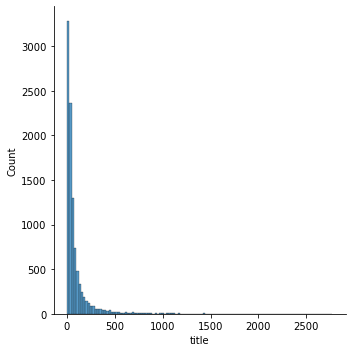

In [52]:
sns.displot(
    to_r.groupby('book_id').count(),
    x='title',
    bins=115
);

## 2. Basic recommender

Overal recommendations based on global rating scores and popularity. Idea is books that are more popular will have higher probability to be universally liked and hence recommend. Not personalized.

### 2.1. Top Rated books: 
- weighted rating = vR/(v+m)+mC/(v+m) from IMDB   
v = number of rating  
m = min ratings required  
R = avg rating of the book  
C = mean rating acorss all the books  

In [53]:
def weighted_rating(df):
    v = df['ratings_count']
    m = df['ratings_count'].quantile(0.95) # rating count > 95%
    R = df['average_rating']
    C = df['average_rating'].mean()
    WR = (v*R + m*C) / (v + m)
    return WR

In [54]:
books['weighted_rating'] = weighted_rating(books)
top_rated_books = books.sort_values('weighted_rating', ascending=False)

In [55]:
top_rated_books[['title', 'authors', 'average_rating', 'weighted_rating', 'ratings_count']].head()

,title,authors,average_rating,weighted_rating,ratings_count
book_id,,,,,
25,Harry Potter and the Deathly Hallows (Harry Po...,"J.K. Rowling, Mary GrandPré",4.61,4.555956,1746574
27,Harry Potter and the Half-Blood Prince (Harry ...,"J.K. Rowling, Mary GrandPré",4.54,4.490428,1678823
18,Harry Potter and the Prisoner of Azkaban (Harr...,"J.K. Rowling, Mary GrandPré, Rufus Beck",4.53,4.485090,1832823
24,Harry Potter and the Goblet of Fire (Harry Pot...,"J.K. Rowling, Mary GrandPré",4.53,4.483227,1753043
2,Harry Potter and the Sorcerer's Stone (Harry P...,"J.K. Rowling, Mary GrandPré",4.44,4.424365,4602479


### 2.2. Top Popular Books:

In [56]:
top_popular_books = books.sort_values('ratings_count', ascending=False)
top_popular_books[['title', 'authors', 'average_rating', 'ratings_count']].head()

,title,authors,average_rating,ratings_count
book_id,,,,
1,"The Hunger Games (The Hunger Games, #1)",Suzanne Collins,4.34,4780653
2,Harry Potter and the Sorcerer's Stone (Harry P...,"J.K. Rowling, Mary GrandPré",4.44,4602479
3,"Twilight (Twilight, #1)",Stephenie Meyer,3.57,3866839
4,To Kill a Mockingbird,Harper Lee,4.25,3198671
5,The Great Gatsby,F. Scott Fitzgerald,3.89,2683664


### 2.3. Top Genres Books:

In [57]:
genres_built_in = built_in_book_tags.merge(built_in_tags, on='tag_id')

In [58]:
def weighted_rating(df):
    v = df['ratings_count']
    m = df['ratings_count'].quantile(0.95) # rating count > 95%
    R = df['average_rating']
    C = df['average_rating'].mean()
    WR = (v*R + m*C) / (v + m)
    return WR

In [59]:
books_genres = books.reset_index().merge(genres_built_in, on='goodreads_book_id')\
[['book_id', 'title', 'authors', 'tag_name', 'count', 'average_rating', 'ratings_count']]
books_genres.rename(columns={'count': 'tag_count'}, inplace=True)
books_genres['weighted_rating'] = books_genres.groupby('tag_name').apply(lambda x: weighted_rating(x)).reset_index([0])[0]
top_rated_books_genres = books_genres.sort_values('weighted_rating', ascending=False)
top_rated_books_genres[['tag_name', 'book_id', 'title', 'authors', 'average_rating',\
                  'weighted_rating', 'ratings_count']].head()

,tag_name,book_id,title,authors,average_rating,weighted_rating,ratings_count
147,mystery,25,Harry Potter and the Deathly Hallows (Harry Po...,"J.K. Rowling, Mary GrandPré",4.61,4.559742,1746574
146,paranormal,25,Harry Potter and the Deathly Hallows (Harry Po...,"J.K. Rowling, Mary GrandPré",4.61,4.554666,1746574
144,fiction,25,Harry Potter and the Deathly Hallows (Harry Po...,"J.K. Rowling, Mary GrandPré",4.61,4.553385,1746574
143,fantasy,25,Harry Potter and the Deathly Hallows (Harry Po...,"J.K. Rowling, Mary GrandPré",4.61,4.553351,1746574
148,romance,25,Harry Potter and the Deathly Hallows (Harry Po...,"J.K. Rowling, Mary GrandPré",4.61,4.551600,1746574


- example

In [60]:
top_rated_books_genres[top_rated_books_genres.tag_name == 'fiction'].head()

,book_id,title,authors,tag_name,tag_count,average_rating,ratings_count,weighted_rating
144,25,Harry Potter and the Deathly Hallows (Harry Po...,"J.K. Rowling, Mary GrandPré",fiction,10012,4.61,1746574,4.553385
163,27,Harry Potter and the Half-Blood Prince (Harry ...,"J.K. Rowling, Mary GrandPré",fiction,9954,4.54,1678823,4.488034
99,18,Harry Potter and the Prisoner of Azkaban (Harr...,"J.K. Rowling, Mary GrandPré, Rufus Beck",fiction,10656,4.53,1832823,4.482900
138,24,Harry Potter and the Goblet of Fire (Harry Pot...,"J.K. Rowling, Mary GrandPré",fiction,10249,4.53,1753043,4.480954
8,2,Harry Potter and the Sorcerer's Stone (Harry P...,"J.K. Rowling, Mary GrandPré",fiction,13239,4.44,4602479,4.423541


## 3. Content-based Filtering
- text features: title, authors, genres
- calculate tfidf, and its cosine similarity

- original features

In [61]:
# original features
books[['books_count', 'authors', 'original_publication_year', 'original_title',
       'title', 'language_code', 'average_rating', 'ratings_count',
       'work_ratings_count', 'work_text_reviews_count', 'weighted_rating']]
# some transformation
books['authors_list'] = books['authors'].apply(lambda x: [author.lower()\
                                                          for author in x.split(', ')])

- generated features:  
- genres_list

In [62]:
# books['genres']
books['genres_list'] = books_genres.groupby('book_id')['tag_name']\
.agg(genres_list=lambda x: [n for n in x])

In [63]:
# title_authors_genres (books' text feature) mix-up
books['title_authors_genres'] = books.apply(lambda x: ' '.join([x['title'].lower()] + x['authors_list'] + x['genres_list']), axis=1)

In [64]:
# title_authors_genres_averagerating (books' text feature) mix-up
books['title_authors_genres_rating'] = books.apply(lambda x: ' '.join([x['title'].lower()] + x['authors_list'] + x['genres_list'] + [str(x['average_rating'])]), axis=1)

- tfidf

In [65]:
content = books[['title', 'authors_list', 'genres_list', 'average_rating', 'title_authors_genres_rating' ]]
content['average_rating'] = content['average_rating'].astype(str)

<ipython-input-65-caedacf853ba>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  content['average_rating'] = content['average_rating'].astype(str)


In [66]:
tfidf = TfidfVectorizer(ngram_range=(1,2), tokenizer=word_tokenize)

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(content['title_authors_genres_rating'])
content_tfidf_cos_similarity =  cosine_similarity(tfidf_matrix, tfidf_matrix)

- count vectorizer

In [67]:
count = CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
cnt_matrix = count.fit_transform(books['title_authors_genres'])
content_cnt_cos_similarity = cosine_similarity(cnt_matrix, cnt_matrix)
title_idx = pd.Series(books.index, index=books['title'].str.lower())
idx_title = books['title'].str.lower()

In [68]:
def book_content_recommendation_cos(title, books=books,books_similarity=content_tfidf_cos_similarity, n=10, a=3):
    """
    input: title -> books name in the books dataset
            n -> number of books to recommend based on content
    output: list of books to recommend
    """
    idx = title_idx[title.lower()]
    similarities = list(enumerate(books_similarity[idx]))
    top_similarities = sorted(similarities, key=lambda x: x[1], reverse=True)[1:a*n+1]
    top_books_idx_candidates = [i for i, _ in top_similarities]
    top_books_candidates = books.iloc[top_books_idx_candidates]
    
    v = top_books_candidates['ratings_count']
    m = top_books_candidates['ratings_count'].quantile(0.8)
    R = top_books_candidates['average_rating']
    C = top_books_candidates['average_rating'].mean()
    top_books_candidates.loc[:, 'weighted_rating'] = (R*v + C*m) / (v + m)
    top_books = top_books_candidates.sort_values('weighted_rating',ascending=False)[:n]

    return top_books[['title', 'weighted_rating', 'ratings_count']]

In [69]:
book_content_recommendation_cos('harry potter and the chamber of secrets (harry potter, #2)', books_similarity=content_tfidf_cos_similarity, n=10)

C:\Users\Sakura\anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


,title,weighted_rating,ratings_count
book_id,,,
25,Harry Potter and the Deathly Hallows (Harry Po...,4.541850,1746574
27,Harry Potter and the Half-Blood Prince (Harry ...,4.487385,1678823
18,Harry Potter and the Prisoner of Azkaban (Harr...,4.483118,1832823
422,"Harry Potter Boxset (Harry Potter, #1-7)",4.433885,190050
21,Harry Potter and the Order of the Phoenix (Har...,4.428292,1735368
2,Harry Potter and the Sorcerer's Stone (Harry P...,4.428072,4602479
1022,"Heir of Fire (Throne of Glass, #3)",4.366575,123843
23,Harry Potter and the Chamber of Secrets (Harry...,4.360538,1779331
3275,"Harry Potter Boxed Set, Books 1-5 (Harry Potte...",4.355119,33220


## 4. Collaborative  Filtering 

In [6]:
# ratingmat = ratings.pivot(index='user_id', columns='book_id', values='rating')
ratingmat = pd.read_csv('rating_pivot.csv', index_col=0)
ratingmat.columns = ratingmat.columns.map(int)
# ratingmat_sparse = csr_matrix(ratingmat)

### 4.1. User based

#### 4.1.1. Matrix Factorization (SVD)

In [71]:
reader = Reader()
ratings_data = Dataset.load_from_df(ratings, reader)
train = ratings_data.build_full_trainset()

In [101]:
svd = SVD()
# cross_validate(svd, ratings_data, n_jobs=-1)
svd.fit(train)

In [102]:
def svd_UB_recommendation(user_id, svd=svd, n=10):
    """
    idea: input user_id, and svd model, which factorizes matrix on raingmat(# user, # items)
          # 
          input: user_id
                 n: number of books to recommend
          output: list of recommended books
    """
    
    user_df = ratings[ratings['user_id'] == user_id].merge(books.title, on='book_id', how='outer')
    user_df.user_id = user_df.user_id.fillna(method='ffill',downcast='infer')
    user_df = user_df[['user_id', 'book_id', 'rating']]
    
    train = Dataset.load_from_df(user_df, reader).build_full_trainset()
    test = train.build_testset()
    est_ratings = svd.test(test)
    top_ratings = pd.DataFrame(sorted([(b, r) for (_, b, _, r, _) in est_ratings],\
                                      key=lambda x: x[1], reverse=True)[:n], \
                              columns=['book_id', 'estimate_ratings']).set_index('book_id')
    
    top_books = books.merge(top_ratings, on='book_id')[['title', 'estimate_ratings']].\
    sort_values('estimate_ratings', ascending=False)
    return top_books

In [104]:
svd_UB_recommendation(12222)

,title,estimate_ratings
book_id,,
18,Harry Potter and the Prisoner of Azkaban (Harr...,5.000000
25,Harry Potter and the Deathly Hallows (Harry Po...,5.000000
27,Harry Potter and the Half-Blood Prince (Harry ...,4.996736
24,Harry Potter and the Goblet of Fire (Harry Pot...,4.989863
422,"Harry Potter Boxset (Harry Potter, #1-7)",4.982445
2,Harry Potter and the Sorcerer's Stone (Harry P...,4.979780
21,Harry Potter and the Order of the Phoenix (Har...,4.913455
23,Harry Potter and the Chamber of Secrets (Harry...,4.851593
862,"Words of Radiance (The Stormlight Archive, #2)",4.801715


### 4.2. Item Based

#### 4.2.1. KNN based on pearson corrlation for books

In [7]:
# pearson_corr = ratingmat.corr()
pearson_corr = pd.read_csv('book_pearson_corr.csv', index_col=0)
pearson_corr.columns = pearson_corr.columns.map(int)

In [73]:
r = ratingmat.fillna(0)

In [74]:
def knn_IB_recommendation_corr(user_id, ratingmat=r.T, pearson_corr=pearson_corr, n=10, thresh=0.85):
    """
    idea: input item-based similarity (pearson correlationo) and user_id,
          calculated weighted rating based on books' similarity (similiarty.dot(rating[user_id])),
          then pick knn as the recommended books (distance is item-based weighted rating).
          
          input: user_id
                 pearson_corr = dataframe of books' pearson corr 
                 n: number of books to recommend
                 thresh: threshold on weighted rating
          output: list of recommended books
    """
    
    R = ratingmat[user_id]
    s = pearson_corr.fillna(0)
    IB_weighted_rating = s.dot(R) / s.sum()
    candidates = pd.concat([books[['title', 'ratings_count', 'average_rating', 'genres_list']], \
                            IB_weighted_rating.rename('wr')], axis=1, join='inner').\
    sort_values('wr', ascending=False)
    
    threshold = candidates.ratings_count.quantile(thresh)
    candidates = candidates[candidates.ratings_count > threshold]

    IB_weighted_rating = s.dot(R)
    return candidates[candidates.ratings_count > threshold][:n]

In [75]:
knn_IB_recommendation_corr(user_id=6)

,title,ratings_count,average_rating,genres_list,wr
book_id,,,,,
990,Rework,88626,3.93,"[ebooks, nonfiction, business, psychology]",0.163668
1174,The Girls,76761,3.49,"[fiction, mystery, contemporary, thriller, ebo...",0.133078
580,The Story of Art,164708,3.83,"[classics, philosophy, history, nonfiction, art]",0.132852
1415,The Lean Startup: How Today's Entrepreneurs Us...,86284,4.04,"[ebooks, nonfiction, business]",0.132369
1539,The Underground Railroad,72052,4.04,"[fantasy, fiction, contemporary, ebooks, history]",0.117632
776,The Art Book,102746,3.79,"[history, nonfiction, art]",0.117538
654,Freedom,119213,3.73,"[fiction, contemporary, ebooks]",0.114388
1404,Catherine the Great: Portrait of a Woman,66591,3.91,"[fiction, classics, ebooks, history, nonfictio...",0.113918
1129,"The History of the Hobbit, Part One: Mr. Baggins",108399,3.81,"[fantasy, fiction, classics, history, nonficti...",0.111389


#### 4.2.2 KNN based on cosine

In [76]:
std_ratingmat_books = ratingmat.T.transform(lambda x: x - x.mean()).fillna(0)
std_ratingmat_books.index.rename('book_id', inplace=True)

In [77]:
%%time
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
knn.fit(std_ratingmat_books)

Wall time: 1.03 s


NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

In [92]:
def knn_IB_recommendation_cos(title, knn=knn, data=std_ratingmat_books, title_idx=title_idx, idx_title=books.title, n=10):
    """
        idea: input pivot user-item dataframe,
              to get similar books, run knn (distance is cos similarity),
              -------
              to get recommended book to user, need to be finished
              
          input: user_id
                 knn: knn model
                 data: pivot user-item dataframe
                 title_idx: book title: book_id dataframe (mapping)
                 idx_title: book_id: book title
                 n: number of books to recommend
                 
          output: list of recommended books
    """
    
    # get similar book by cos similarity
    knn.fit(data)
    book_id = title_idx[title]
    sims, candidates_ids = knn.kneighbors(data.loc[book_id, :].values.reshape(1, -1), n_neighbors=n+1)
    candidates_dis_ids = list(zip(sims[0], idx_title[candidates_ids[0]+1]))[1:]
    
    # knn below need to be finished
#     R = data[user_id]
#     s = sims.fillna(0)
#     IB_weighted_rating = s.dot(R) / s.sum()
    # sort by weighted rating, then get books
    return [b for _, b in candidates_dis_ids]

In [93]:
idx_title[2]

"harry potter and the sorcerer's stone (harry potter, #1)"

In [94]:
knn_IB_recommendation_cos("harry potter and the sorcerer's stone (harry potter, #1)")

['Harry Potter and the Prisoner of Azkaban (Harry Potter, #3)',
 'Harry Potter and the Chamber of Secrets (Harry Potter, #2)',
 'Harry Potter and the Goblet of Fire (Harry Potter, #4)',
 'Harry Potter and the Half-Blood Prince (Harry Potter, #6)',
 'Harry Potter and the Deathly Hallows (Harry Potter, #7)',
 'Harry Potter and the Order of the Phoenix (Harry Potter, #5)',
 'The Hunger Games (The Hunger Games, #1)',
 'The Help',
 'Harry Potter Boxset (Harry Potter, #1-7)',
 'Catching Fire (The Hunger Games, #2)']

## 5. Hybrid Recommendation

### 5.1. Personal_books_recommendtaion combined content based and collaborative filtering

In [105]:
def personal_books_recommendation(user_id, book_id=None, title='', 
                                  cos_similarity=content_tfidf_cos_similarity, n=10, a=0.5):
    '''
    idea: first filter by content based system (cos similarity of tfidf (text features) ),
                Second filter by Collaborative  Filtering (user based MF(SVD) ) 
                
    input: user ID and Book ID/Title
            a: 0-1, importance of personalized rating
    output: similar books recommend to certain user

    '''
    
    
    if title:
        book_id = title_idx[title.lower()]
        
    # content based filtering  
    books_content_similarities = list(enumerate(cos_similarity[book_id-1], start=1))
    books_content_similarities.sort(key=lambda x: x[1], reverse=True)
    top_books_content_similarities = books_content_similarities[1:5*n+1]
    top_books_id = [i for i, _ in top_books_content_similarities]
    top_books_candidates = books.loc[top_books_id, ['title',  'ratings_count', 'average_rating']]
    v = top_books_candidates['ratings_count']
    m = top_books_candidates['ratings_count'].quantile(0.8)
    R = top_books_candidates['average_rating']
    C = top_books_candidates['average_rating'].mean()
    top_books_candidates['weighted_rating'] = round((R*v + C*m) / (v + m), 2)
    
    # collaborative filtering (user based)
    top_books_candidates['estimate_rating'] = top_books_candidates.index.\
                                                    map(lambda x: round(svd.predict(user_id, x).est, 2) )
    top_books_candidates['final_rating'] = round( (a * top_books_candidates['estimate_rating']) + \
                                        ((1-a) * top_books_candidates['weighted_rating']), 2 )
    top_books = top_books_candidates.sort_values('final_rating', ascending=False)
    return top_books[:n]

In [106]:
personal_books_recommendation(10, 2)

,title,ratings_count,average_rating,weighted_rating,estimate_rating,final_rating
book_id,,,,,,
422,"Harry Potter Boxset (Harry Potter, #1-7)",190050,4.74,4.46,4.51,4.48
25,Harry Potter and the Deathly Hallows (Harry Po...,1746574,4.61,4.57,4.37,4.47
18,Harry Potter and the Prisoner of Azkaban (Harr...,1832823,4.53,4.50,4.41,4.46
27,Harry Potter and the Half-Blood Prince (Harry ...,1678823,4.54,4.50,4.34,4.42
24,Harry Potter and the Goblet of Fire (Harry Pot...,1753043,4.53,4.50,4.34,4.42
3753,"Harry Potter Collection (Harry Potter, #1-6)",24618,4.73,4.25,4.58,4.42
3736,Harry Potter Page to Screen: The Complete Film...,27361,4.56,4.24,4.45,4.35
21,Harry Potter and the Order of the Phoenix (Har...,1735368,4.46,4.43,4.23,4.33
2101,"The Harry Potter Collection 1-4 (Harry Potter,...",43929,4.66,4.28,4.32,4.30


### 5.2. Model based Filtering (target is whether user want to read the books)

- idea: build model for each user  
  input: user personal ratings and books content data,    
  output: for each book, want to read or not ( 0/1)

#### 5.2.1. preprocessing

In [53]:
# user = to_read.merge(ratings, how='outer', on='user_id', suffixes=('_tr', '_rating'))

In [107]:
b_cols = ['books_count', 'original_publication_year',
           'average_rating', 'ratings_count',
       'work_ratings_count', 'work_text_reviews_count', 'ratings_1',
       'ratings_2', 'ratings_3', 'ratings_4', 'ratings_5', 'n_authors', 
        'years_until_now', 'title_changed',
       'title_length', 'has_subtitle', 'is_english',
       'n_books_in_series', 'n_user_to_read', 'weighted_rating']


In [108]:
def data_preprocess_user(user_id, data=None):
    ordinal = OrdinalEncoder()
    lang_ord = ordinal.fit_transform(pd.DataFrame(books['language_code'].fillna('')))
    lang_ord = pd.DataFrame(lang_ord, columns=['language_code']).astype(int)
    lang_ord.index += 1
    lang_ord.index.name = 'book_id'

    user_factor = svd.pu
    user1 = user_factor[0].reshape(1, -1) # users rating/interaction factors extracted by svd
    r1 = ratings[ratings.user_id==user_id].set_index('book_id')
    tr1 = to_read[to_read.user_id==user_id].set_index('book_id')
    tr1['to_read'] = 1
    books_features = books[b_cols]
    books_text_features = tfidf_matrix.copy() # book content extracted by tfidf
    books_factor = svd.qi  # books rating/interaction factors extracted by svd
    
    
    
    
    # 1. join  
    # 2. create est rating for nan personal rating, fill nan with 0 in (to_read), 
    #    but with 1 with those rating > 0.8 quantile
    # 3. split data to X_train, X_val, X_test (with true rating, with to_read info, 
    #    no true rating and no to_read info)
    books_u1 = books_features.join(r1.rating, on='book_id').\
        join(lang_ord, on='book_id').join(tr1.to_read, on='book_id')
    train_idx, val_idx, test_idx = \
                        books_u1[books_u1.rating.notna()].index, \
                        books_u1[books_u1.to_read.notna()].index, \
                        books_u1[books_u1.to_read.isna() & books_u1.rating.isna()].index

    # fill na personal rating with svd est rating
    tmp = books_u1[books_u1.rating.isna()].rating.reset_index()
    tmp.rating = tmp.book_id.transform(lambda x: round(svd.predict(1, x).est, 3))
    tmp = tmp.set_index('book_id')
    books_u1.loc[books_u1.rating.isna(), 'rating'] = tmp

    # fill train set na to_read = 1 by those est rating in val 
    # set (to read=1) > pre-define threshold (median)
    threshold_to_read = books_u1[books_u1.to_read.notna()].rating.quantile(0.5)
    tmp_idx = books_u1.loc[train_idx, 'to_read'] \
    [books_u1.loc[train_idx].rating > threshold_to_read].index
    books_u1.loc[books_u1.to_read.isna(), 'to_read'] = 0
    books_u1.loc[tmp_idx, 'to_read'] = 1

    X_cols = books_u1.columns[:-1]
    y_col = books_u1.columns[-1]

    X = books_u1[X_cols]
    y = books_u1[y_col]
    tsvd = TruncatedSVD(100)
    books_text_features_svd = tsvd.fit_transform(books_text_features)

    books_text_features_svd_df = pd.DataFrame(books_text_features_svd).\
                                add_prefix('text_features_svd')
    books_text_features_svd_df.index += 1
    books_factor_df = pd.DataFrame(books_factor).add_prefix('books_factor')
    books_factor_df.index += 1
    user_factor_df = pd.DataFrame(np.repeat(user1, len(X), axis=0) )\
    .add_prefix('user_factor')
    user_factor_df.index += 1

    X = pd.concat((X, books_text_features_svd_df, books_factor_df, user_factor_df),axis=1)
    X_cols = X.columns
    X_train, X_val, X_test = X.loc[train_idx], X.loc[val_idx], X.loc[test_idx]
    y_train, y_val, y_test = y.loc[train_idx], y.loc[val_idx], y.loc[test_idx]
    if data is not None:
        X_test = X.loc[data.index]
        y_test = y.loc[data.index]
    return [(X_train, y_train), (X_val, y_val), (X_test, y_test)]


In [109]:
(X_train, y_train), (X_val, y_val), (X_test, y_test) = data_preprocess_user(1)

#### 5.2.2. Training using xgboost
#### ~~(5.2.3.) parameter tuning (cross validation to tune, but given time limit, leave for future)~~

In [112]:
xgbdt = xgb.XGBClassifier(
    n_estimators=2000,
    use_label_encoder=False,
    learning_rate = 0.01,
#     max_depth=10,
#     objective='binary:logistic',
    booster='gbtree',

    
    n_jobs=-1,
    verbosity=0
                         )

In [114]:
xgbdt.fit(X_train, 
          y_train,
#           eval_set=((X_train, y_train), (X_val, y_val)),
          
#           eval_metric='aucpr', 
         )

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=2000, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=0)

#### 5.2.4. Evaluation:  **AUC** in general, but depends
since we recommend book from a huge list or from pre-recommend list, might come from distribution where many books are not liked by people or liked, which is imbalanced data set, accruacy should not be the metric, but should use precision, recall etc., and hence use PR AUC to get evaluate in this general case

In [117]:
y_pred = pd.DataFrame(xgbdt.predict(X_train), index=X_train.index).sort_values(0)
y_true = y_train.reindex(y_pred.index)
a = pd.concat((y_true.rename('y_ture'), y_pred.rename(columns={0: 'y_pred'}) ), axis=1)

In [118]:
a = precision_recall_curve(y_train, [i for _, i in(xgbdt.predict_proba(X_train))])
auc(a[1], a[0])

1.0

In [120]:
b = precision_recall_curve(y_val, [i for _, i in(xgbdt.predict_proba(X_val))])
auc(b[1], b[0])

0.9999999999999998

#### 5.2.5. Prediction of to_read (to support recommendations), only use user1 for now

In [121]:
models = {}
models[1] = xgbdt

In [122]:
def personal_books_recommendation_xgb(user_id=1, books=books, n=10):
    (X_train, y_train), (X_val, y_val), (X_test, y_test) = \
                                data_preprocess_user(user_id, data=books)
    model = models[user_id]
    tops = np.concatenate((model.predict_proba(X_test), model.predict(X_test).reshape(-1, 1)), axis=1)
    top_books = pd.DataFrame(tops, \
                             index=X_test.index, columns=['0','prob', 'want_to_read']).\
                            sort_values('prob', ascending=False)[:n]
    return books.merge(top_books, on='book_id')[['title', 'prob', 'want_to_read']]

In [123]:
personal_books_recommendation_xgb(user_id=1, books=books[:3400], n=5)

,title,prob,want_to_read
book_id,,,
628,"Patriot Games (Jack Ryan Universe, #2)",0.984319,1.0
1131,"Chocolat (Chocolat, #1)",0.984300,1.0
1203,Aristotle and Dante Discover the Secrets of th...,0.984319,1.0
1581,Hawaii,0.984300,1.0
1857,In the Hand of the Goddess (Song of the Liones...,0.984319,1.0


## 6. Information Retrieval

- idea:  
  1. divide and classify query: title, author, genres, tags_diy  ------------------------------ to do (NLP task), only support title for now
  2. calculte tfidf cos similarity between query and each dataset tfidf values (title for instance here)  
  3. sort by similarity, and choose top matched query (e.g. title)

- preprocess text features for classification / clustering

In [124]:
title = books['original_title'].fillna(books.title).str.lower().rename('title', inplace=True)

authors = books['authors'].apply(lambda x:  x.lower().split(',')).explode().\
str.strip().drop_duplicates().reset_index(drop=True).rename('authors', inplace=True)

genres = pd.Series(genres_built_in.tag_name.unique()).rename('genres', inplace=True)

tags_diy = pd.Series(tags.tag_name.str.lower().unique()).\
map(lambda x: re.sub(r'[^\x00-\x7F]+', ' ', x)).\
replace('-', '').replace(r'^\s*$', np.nan, regex=True).dropna().drop_duplicates().rename('tags_diy', inplace=True)

docs = [title, authors, genres, tags_diy]

In [125]:
tfidfs = {}
for doc in docs:
    tfidf = TfidfVectorizer(ngram_range=(1, 2), tokenizer=word_tokenize)
    X = tfidf.fit_transform(doc)
    tfidfs[doc.name] = (tfidf, X)

In [126]:
def query_similar_items(q, doc, tfidfs=tfidfs):
    idx = 0
    if doc == 'title':
        idx = 1
        
    q = [q]
    tfidf, doc_vec = tfidfs[doc]
    q_vec = tfidf.transform(q)
    sim = pd.DataFrame(sorted(list(enumerate(cosine_similarity(q_vec, doc_vec)[0], idx)),\
                              key=lambda x: x[1], reverse=True), columns=['book_id', 'cos_similarity']).\
                              set_index('book_id')
    return sim

In [127]:
a = query_similar_items('harry potter 2', 'title')
a.merge(books.title, on='book_id')

,cos_similarity,title
book_id,,
3753,0.617575,"Harry Potter Collection (Harry Potter, #1-6)"
6141,0.518223,Harry Potter and the Order of the Phoenix (Har...
3275,0.510482,"Harry Potter Boxed Set, Books 1-5 (Harry Potte..."
422,0.483588,"Harry Potter Boxset (Harry Potter, #1-7)"
27,0.467086,Harry Potter and the Half-Blood Prince (Harry ...
...,...,...
9996,0.000000,"Bayou Moon (The Edge, #2)"
9997,0.000000,"Means of Ascent (The Years of Lyndon Johnson, #2)"
9998,0.000000,The Mauritius Command


## 7. Personalized Book Search

### 7.1 helper function from above (1-6)

In [128]:
def query_similar_items(q, doc, tfidfs=tfidfs):
    """
    idea:  
      1. divide and classify query: title, author, genres?  -- unsupurvise, LDA?
      2. use pre-calculated tfidf from each dataset to calculate similarity with query
      3. return similarity score descending
      
      input: 
          query: string
          doc: string
          tfidfs: pre-calculated tfidf from different datasets
      output:
          top similarity: DataFrame
    """
    idx = 0
    if doc == 'title':
        idx = 1
        
    q = [q]
    tfidf, doc_vec = tfidfs[doc]
    q_vec = tfidf.transform(q)
    sim = pd.DataFrame(sorted(list(enumerate(cosine_similarity(q_vec, doc_vec)[0], idx)),\
                              key=lambda x: x[1], reverse=True), columns=['book_id', 'cos_similarity']).\
                              set_index('book_id')
    return sim
def personal_books_content_recommendation(book_id, sim=content_tfidf_cos_similarity, n=5):
        books_content_similarities = list(enumerate(sim[book_id-1], start=1))
        books_content_similarities.sort(key=lambda x: x[1], reverse=True)
        top_books_content_similarities = books_content_similarities[:n]
        top_books = pd.DataFrame(top_books_content_similarities, columns=['book_id', 'similarity']). \
                                set_index('book_id')
        return top_books

def weighted_rating(df):
    v = df['ratings_count']
    m = df['ratings_count'].quantile(0.95) # rating count > 95%
    R = df['average_rating']
    C = df['average_rating'].mean()
    WR = round((v*R + m*C) / (v + m), 3)
    return WR

def personal_books_CF_userbased_recommendation(user_id, books=books, n=10, a=0.5):
    '''
    idea: first filter by content based system (cos similarity of count (text features) ),
                Second filter by Collaborative  Filtering (user based MF(SVD) ) 
                
    input: user ID and Book ID/Title
            a: 0-1, importance of personalized rating
    output: similar books recommend to certain user

    '''
    CF_books = books.copy()
    # collaborative filtering (user based)
    CF_books['estimate_rating'] = books.index.\
                                                    map(lambda x: round(svd.predict(user_id, x).est, 3) )
    CF_books['final_rating'] = round( (a * CF_books['estimate_rating']) + \
                                        ((1-a) * CF_books['content_rating']), 3 )
#     top_books = books.sort_values('final_rating', ascending=False)
    return CF_books

def personal_books_recommendation_xgb(user_id=1, books=books, n=10):
    (X_train, y_train), (X_val, y_val), (X_test, y_test) = \
                                data_preprocess_user(user_id, data=books)
    model = models[user_id]
    tops = np.concatenate((model.predict_proba(X_test), model.predict(X_test).reshape(-1, 1)), axis=1)
    top_books = pd.DataFrame(tops, \
                             index=X_test.index, columns=['0','prob', 'want_to_read']).\
                            sort_values('prob', ascending=False)[:n]
    return books.merge(top_books, on='book_id')[['title', 'prob', 'want_to_read']]

### 7.2. Final personalized Books Search System

In [129]:
def personalized_books_search(user_id, q, doc='title', n=10, \
                              search_neighbor=10, content_neighbor=20,\
                              recommend_alpha=0.5, to_read_filter=True
                              ):
    """
       idea: 
             1. query similar books (tfidf cos similarity)
             2. for each queryed book in above list, use content-based and Collaborative filtering (user based, MF: SVD)
                to recommend books, giving another books list
             3. Collect all the books above, calculate their final rating, formula:
               final rating = query similarity * ( a*(CF user based rating) + (1-a)*(content based weighted rating) ) 
             4. if to_read_filter is True, use xgboost to predict whether user wants to read the above book list, 
                filter out those want_to_read = 0
             5. rank over the book list, pick top n books to recommend
        
        input:
             user_id: user_id
             q: query (only support title-liked string for now, otherwise, result might not be good)
             doc: type of query (only support title for now)
             n: number of books to recommend
             search_neighbor: number of books candidates in search list (intermediate state)
             content_neighbor: number of books candidates in content-based filtering list (intermediate state)
             recommend_alpha: weight of Collaborative filtering recommender, [0, 1]
             to_read_filter: whether use model based filtering to etimate whether user wants to read the books or not, and filter them
        
        output:
             list of recommend books: DataFrame
    """
    q_cos_sims = query_similar_items(q, doc, tfidfs)[:search_neighbor]
    q_cos_sims = q_cos_sims.transform(lambda x: x / x.iloc[0])
    top_books = []
    for book_id, q_sim in q_cos_sims.iterrows():
        c_books = personal_books_content_recommendation(book_id, n=content_neighbor)
        top_books_candidates = c_books.merge(books, on='book_id')[['ratings_count', 'average_rating']]
        top_books_candidates['content_rating'] = weighted_rating(top_books_candidates)
        
#         top_books_candidates['svd_rating'] = c_books_candidates.index.map(lambda x: round(\
#                                             svd.predict(user_id, x).est, 3) )
#         top_books_candidates['final_rating'] = round( search_alpha * q_sim[0] * 
#                                                          ( content_alpha * \
#                                                          top_books_candidates['weighted_rating'] + \
#                                                           (1-content_alpha) * \
#                                                          top_books_candidates['svd_rating'] )
#                                                      , 3 )
        top_books_final_rating = q_sim[0] * personal_books_CF_userbased_recommendation\
                    (user_id, books=top_books_candidates, n=-1, a=recommend_alpha)['final_rating']
        top_books.append(top_books_final_rating)
        
    top_books_df = pd.DataFrame(pd.concat(top_books))
    top_books_df = top_books_df.merge(books.title, on='book_id').groupby('book_id').max()
    
    # use machine learning to predict whether user wants to read or not (filter)
    if to_read_filter:
        books_to_read = personal_books_recommendation_xgb(user_id, top_books_df, n=-1)
        top_books_df = top_books_df.loc[books_to_read[books_to_read.want_to_read==1].index]

    return top_books_df.sort_values('final_rating', ascending=False)[:n]\
# .drop('final_rating', axis=1)

- if to_read_filter is True, only user_id = 1 can be queried (reason behind: for each user, build a personalized model or a huge mix-up model for all user to predict whether they want to read the books, but given time and machine limits, couldn't train all the models )

- Multiple examples

In [131]:
user_id=1
q = 'harry potter'
doc = 'title'
personalized_books_search(user_id, q, doc, n=10, search_neighbor=10, \
                          content_neighbor=20, recommend_alpha=0.6, to_read_filter=True)

,final_rating,title
book_id,,
3275,4.295,"Harry Potter Boxed Set, Books 1-5 (Harry Potte..."
3753,4.254,"Harry Potter Collection (Harry Potter, #1-6)"
2101,4.207,"The Harry Potter Collection 1-4 (Harry Potter,..."
3736,4.146,Harry Potter Page to Screen: The Complete Film...
7523,4.139,Hogwarts: An Incomplete and Unreliable Guide (...
18,4.138,Harry Potter and the Prisoner of Azkaban (Harr...
25,4.125,Harry Potter and the Deathly Hallows (Harry Po...
422,4.099,"Harry Potter Boxset (Harry Potter, #1-7)"
8369,4.093,"Harry, a History: The True Story of a Boy Wiza..."


In [132]:
user_id=232
q = 'horrible story'
doc = 'title'
personalized_books_search(user_id, q, doc, n=10, search_neighbor=10, \
                          content_neighbor=20, recommend_alpha=0.6, to_read_filter=False)

,final_rating,title
book_id,,
7615,3.971000,Drinking: A Love Story
7326,3.959000,Doctors
2781,3.925261,A Grief Observed
8843,3.919000,The Invisible Wall: A Love Story That Broke Ba...
1602,3.888516,"Changes (The Dresden Files, #12)"
8936,3.870401,Ghettoside: A True Story of Murder in America
688,3.859997,Under the Banner of Heaven: A Story of Violent...
4594,3.856214,Love Warrior
2034,3.824000,"Bloodsucking Fiends (A Love Story, #1)"


In [133]:
user_id=232
q = 'love and hate'
doc = 'title'
personalized_books_search(user_id, q, doc, n=10, search_neighbor=10, \
                          content_neighbor=20, recommend_alpha=0.6, to_read_filter=False)

,final_rating,title
book_id,,
2140,4.182,"Caliban's War (The Expanse, #2)"
910,4.151,"Old Man's War (Old Man's War, #1)"
820,4.145,The Remains of the Day
9443,4.094,"Rumors of War (Children of the Promise, #1)"
2411,4.083,"The Winds of War (The Henry Family, #1)"
914,4.079,"The Forever War (The Forever War, #1)"
5198,3.997,Of Love and Shadows
300,3.992,The Boy in the Striped Pajamas
3772,3.987,"War and Remembrance (The Henry Family, #2)"


In [154]:
user_id=232
q = 'gone with the wind'
doc = 'title'
personalized_books_search(user_id, q, doc, n=10, search_neighbor=10, \
                          content_neighbor=5, recommend_alpha=0.7, to_read_filter=False)

,final_rating,title
book_id,,
8652,3.955000,"The Wind Singer (Wind on Fire, #1)"
3566,3.906000,Black Swan Green
5021,3.766000,"Own the Wind (Chaos, #1)"
2519,3.683000,"When the Wind Blows (When the Wind Blows, #1)"
66,3.619000,Gone with the Wind
3262,1.934038,"The Talented Mr. Ripley (Ripley, #1)"
8653,1.865215,The End of Mr. Y
4628,1.734051,Er ist wieder da
5251,1.631813,The Dressmaker
